# Weight calculation in non-local means algorithm

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#reading image
img=cv2.imread('brick.png')

#converting image to grayscale
try:
    row, col, ch = img.shape
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   
except:
    print('Image already grayscale')

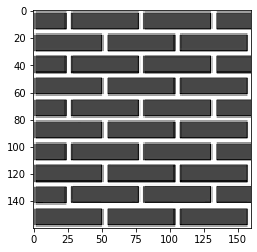

In [4]:
plt.imshow(img, cmap='gray')

In [5]:
# creating a class to calculate the weights assigned to other pixels
class NlMeansWeights():
    '''Calculates weights for pixel at position 'loc' within the (2*searchWindowSize+1) sided square window in img'''
    
    def __init__(self, loc, img, templateWindowSize, searchWindowSize):
        
        self.loc_row, self.loc_col = loc
        self.img_row, self.img_col = img.shape
        self.img = img
        self.templateWindowSize = templateWindowSize
        self.searchWindowSize = searchWindowSize
        
        #padding image to ensure that all pixels lie in (2*templateWindowSize +1) square
        self.padded = np.pad(img, ((templateWindowSize,templateWindowSize),(templateWindowSize,templateWindowSize)), 'constant')

    
    def getSearchWindow(self, row, col, WindowSize):
        '''Gives the coordinates of the window centered at (row, col)'''
        Window = {'left':max(0, col - WindowSize), 'right':min(self.img_col-1, col + WindowSize),
                  'top':max(0, row - WindowSize), 'bottom':min(self.img_row-1, row + WindowSize)}
        return Window
    
    
    def calculateWeight(self, target_loc, h):
        '''Returns the weight assigned to a particular pixel. Prescription similar to http://www.ipol.im/pub/art/2011/bcm_nlm/ is followed.'''
        if h==0:
            h = np.std(self.img)    # might have to be adjusted as per the image 
        row, col = target_loc
        
        diff = np.sum(np.square(np.subtract(self.padded[self.loc_row:self.loc_row+2*self.templateWindowSize, self.loc_col:self.loc_col+2*self.templateWindowSize],
                                            self.padded[row:row+2*self.templateWindowSize, col:col+2*self.templateWindowSize])))
        weight = np.exp(-(diff/(h*h)))
        return weight
    
    
    def findWeights(self, h=0):
        '''Returns the weight assigned to all pixels within the searchWindowSize. h is related to the std dev of the image. Larger the h, larger would be the weights.'''
        searchWindow = self.getSearchWindow(self.loc_row, self.loc_col, self.searchWindowSize)
        weights = np.zeros(self.img.shape)
        
        for row in range(searchWindow['top'], searchWindow['bottom']+1):
            for col in range(searchWindow['left'], searchWindow['right']+1):
                weights[row, col] = self.calculateWeight((row, col), h)
        weights[self.loc_row-2:self.loc_row+2, self.loc_col-2:self.loc_col+2]=0    #because of large weights near to target pixel, weights at other locations get undermined
        weights = weights/np.sum(weights)
        
        return weights        

In [6]:
# calculating wieghts
try1 = NlMeansWeights((80, 80), img, 7, 40)
weights = try1.findWeights(h=45)

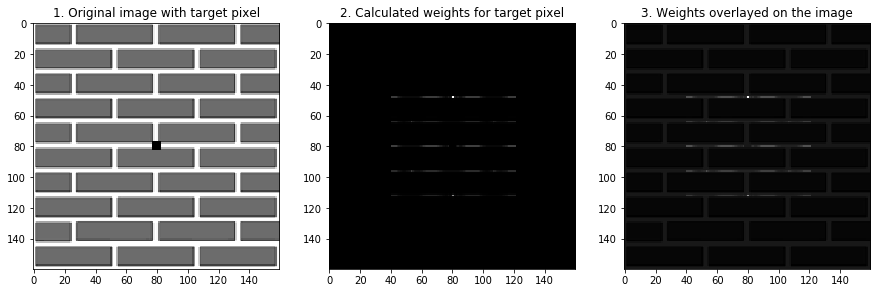

In [7]:
# plotting image with weights

fig, ax = plt.subplots(1,3, figsize=(15, 15))

img2 = img.copy()
img2[77:83, 77:83]=0
ax[0].imshow(img2, cmap='gray')
ax[1].imshow(weights, cmap='gray')
ax[2].imshow(weights, cmap='gray')
ax[2].imshow(img, cmap='gray', alpha=0.1)
ax[0].title.set_text('1. Original image with target pixel')
ax[1].title.set_text('2. Calculated weights for target pixel')
ax[2].title.set_text('3. Weights overlayed on the image')

Target pixel is darkened in the image 1 <br>
The image 2 shows the weights assigned to the pixels lying in the SearchWindow. Brighter the color, larger the weight. The pixels adjacent to the target have been excluded from weight calculation because their similarity cause them to overshadow other region.<br> 
In 3, weights have been layered with the original image. As can be seen, larger weight is primarily assigned to the region between bricks. Though unlike the example in https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/Buades-NonLocal.pdf, weights are not concentrated at selected points. 

## What if the image has variable illumination?

In [8]:
from numpy.random import randn

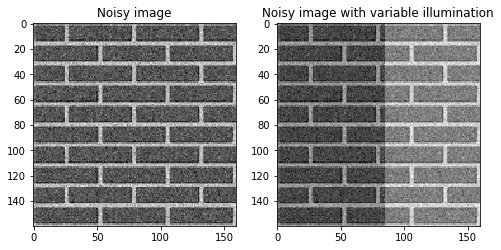

In [31]:
stddev = 25
mean = 0

noisy = img + (stddev*randn(img.shape[0], img.shape[1]) + mean).astype(int)
noisy_bright = noisy.copy()
noisy_bright[:, 85:160]+=100

fig, ax = plt.subplots(1,2, figsize=(8, 8))
ax[0].imshow(noisy, cmap='gray')
ax[1].imshow(noisy_bright, cmap='gray')
ax[0].title.set_text('Noisy image')
ax[1].title.set_text('Noisy image with variable illumination')

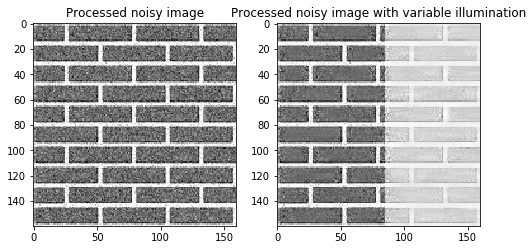

In [14]:
processed_noisy = np.zeros(noisy.shape)
processed_noisy_bright = np.zeros(noisy_bright.shape)
processed_noisy = cv2.fastNlMeansDenoising(np.clip(noisy, 0, 255).astype(np.uint8), processed_noisy,20, 10, 20)
processed_noisy_bright = cv2.fastNlMeansDenoising(np.clip(noisy_bright, 0, 255).astype(np.uint8), processed_noisy_bright,20, 10, 20)

fig, ax = plt.subplots(1,2, figsize=(8, 8))
ax[0].imshow(np.clip(noisy, 0, 255).astype(np.uint8), cmap='gray')
ax[1].imshow(processed_noisy_bright, cmap='gray')
ax[0].title.set_text('Processed noisy image')
ax[1].title.set_text('Processed noisy image with variable illumination')

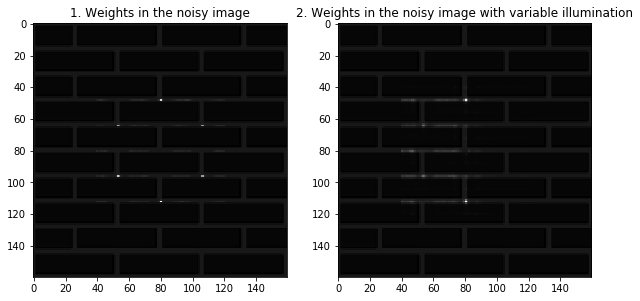

In [181]:
try1 = NlMeansWeights((80, 80), noisy, 7, 40)
weights_noisy = try1.findWeights(350)

try1 = NlMeansWeights((80, 80), noisy_bright, 7, 40)
weights_noisy_bright = try1.findWeights(575)

fig, ax = plt.subplots(1,2, figsize=(10, 10))

ax[0].imshow(weights_noisy, cmap='gray')
ax[0].imshow(img, cmap='gray', alpha=0.1)
ax[1].imshow(weights_noisy_bright, cmap='gray')
ax[1].imshow(img, cmap='gray', alpha=0.1)
ax[0].title.set_text('1. Weights in the noisy image')
ax[1].title.set_text('2. Weights in the noisy image with variable illumination')

In case of similar illumination, weight distribution by the Nl-means is as expected. Though, in case of variable illumination, Nl-means does not identify the similar pixels lying in the region with different illumination. This is demonstrated by the above example. In the case of almost uniform background light, Nl-means was able to find the pixels similar to the target pixel within the SearchWindow. But, for the different illumination case, only those similar pixels are identified which have similar background light. <br>
Solving this issue might improve the performance of Nl-means.

### Variable Illumination? Normalize Background!

In [50]:
import scipy.fftpack

In [175]:
def bg_normalize(bimg, imgindoimgSize=2):
    '''taking fourier transform of image 'bimg' '''
    fourier=np.fft.fft2(bimg)
    shiftF=np.fft.fftshift(fourier)

    # creating a loimg pass version of image
    roimg, col = bimg.shape
    
    for i in np.arange(int(roimg/2)-imgindoimgSize, int(roimg/2)+imgindoimgSize):
        for j in np.arange(int(col/2)-imgindoimgSize, int(col/2)+imgindoimgSize):
            shiftF[i][j]=shiftF[i][j]*0.4    # reducing the contribution to background (DC) intensity  

    #inverse FT of frequency image
    IF1=np.fft.ifft2(shiftF, s=None, norm=None)
     
    return (abs(IF1))

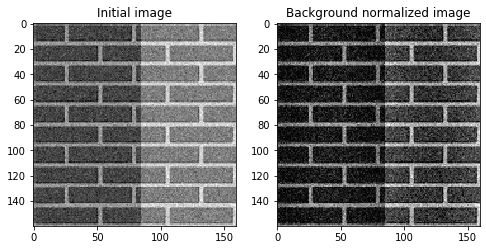

In [180]:
norm = bg_normalize(noisy_bright, 2)

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(noisy_bright, cmap='gray')
ax[1].imshow(norm, cmap='gray')
ax[0].title.set_text('Initial image')
ax[1].title.set_text('Background normalized image')

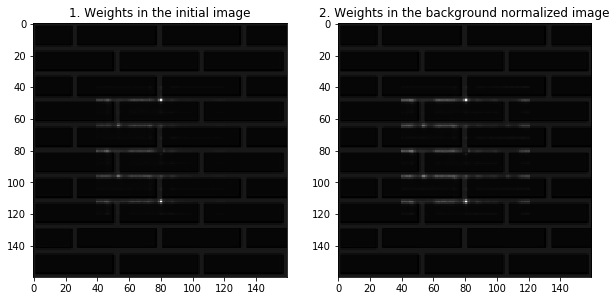

In [187]:
try1 = NlMeansWeights((80, 80), noisy_bright, 7, 40)
weights_noisy = try1.findWeights(600)

try1 = NlMeansWeights((80, 80), norm, 7, 40)
weights_noisy_bright = try1.findWeights(500)

fig, ax = plt.subplots(1,2, figsize=(10, 10))

ax[0].imshow(weights_noisy, cmap='gray')
ax[0].imshow(img, cmap='gray', alpha=0.1)
ax[1].imshow(weights_noisy_bright, cmap='gray')
ax[1].imshow(img, cmap='gray', alpha=0.1)
ax[0].title.set_text('1. Weights in the initial image')
ax[1].title.set_text('2. Weights in the background normalized image')

As can be seen, weights in the normalized image are distributed more uniformly. This raises a question that will normalizing background illumination improve thwe results of Nl-means algorithm?